# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable

---

## Authors

Ângelo Figueiral, Diogo Nasser, Pedro Rolim, and Ricardo Araújo.

---

## External links and resources

Lisbon metro stations: http://dados.cm-lisboa.pt/dataset/estacoes-de-metro

---

## Introduction

In the age of smartphones, reality-simulating videogames, self-driving cars (and AI in general), one often feels disconected from nature, and prossibly even from reality. These global feelings seem to have been deepened even further by the COVID-19 pandemic, especially in big cities. **Green parks** are often the only quick escape that people in big cities like Lisbon and Porto have from the stress, noises, and smells of urban life. While going to these places is ultimately in the hands of the people, there is a lot that municipalities can do to make these places more attractive. A [paper](http://media1.cagd.co.uk/7/696497_8bf035.pdf) from 2002 on a study conducting in England provides some crucial insight for cities to attain just that - more attractive parks:

#### Some general characteristics to attract people idenfitified in the literature are:
- Being free, of open access all day, every day, with non discriminatory access;
- Having events and activities specifically targeted to young people;
- Design is key: District and local green spaces that are a community resource need to be designed with and for the community that will use them, requiring a different approach and different skills from the designer.

#### The same piece of research also shows that:

- Urban green spaces can act as catalysts for wider community initiatives in ways that no other public facility seems able to achieve in similar circumstances.
- Many policymakers have underestimated the role that urban green space can play in urban regeneration. Many still think of parks and other urban green spaces as just ‘greenery’ or ‘landscaping’ and far removed from what they perceive to be the real problems of urban communities.
- Some 32% of people in urban areas are either non-users or infrequent users of urban green spaces.
-  Access issues are very significant.

**Because policymakers are the ones able to gradually create change, it is crucial to demonstrate them exactly how important green spaces are to urban regeneration and to urban communities in general, and precisely in which direction parks should change if they are to attract more people.**


### Our Goal

To find some crucial attributes for Portuguese cities, below we will be using a dataset with **64 green parks in the cities of Lisbon and Porto**, with the average demand for those places.

Because 64 rows is not enough to create very statistically significant models, we will also conduct a deep **qualitative** analysis in the process. We just hope not to bore you :) However, rest assured! We will also try and make the best of this dataset, mainly by trying out some different regression methods and a decision tree - to predict demand. While we expect high error rates, we hope to obtain the importance of the features in the output model, in order to understand **what features matter the most**. It is also worth noticing that these features are also not that extensive, as we did identify **the need to have more detailed data on each park**, mainly on the topics of their role in the society, accessibility, design features, etc.

Because literature suggests that accessibility is key, we also applied our best model (obtained after trying out some fits to the Lisbon data) **to this dataset with a column with the park's distance to its nearest metro station**, in order to check the differences in the importance of that feature and check if the prediction capacity improves. We identified the improvement possibility of including bus stops and even other transportation methods, in order to get a more comprehensive solution - even with the few datapoints available.

---

# Table of Contents

1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Baseline Model](#Baseline-Model---Lisbon-Data)
4. [Getting a Better Model (Spoiler Alert!)](#Getting-a-Better-Model)
5. [Parks Near vs Far Away From Metro Stations (Lisbon)](#Parks-Near-vs-Far-Away-From-Metro-Stations-(Lisbon))
6. [Conclusions](#Conclusions)
7. [Future Work](#Future-Work)

## Development

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib.request, json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [153]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

---

### Exploratory Data Analysis

In [2]:
green_df = pd.read_csv('./data/WDL_Green_Areas_Dataset_V1.csv', sep='|', encoding='latin-1')

In [3]:
green_df

,Green_Zone_name,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Resident,Daily average of people in influence area,Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y
0,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,1,17780.803014,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001
1,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,0,45787.629298,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001
2,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,0,42877.741202,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674
3,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,1,17497.825376,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674
4,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,0,42877.741202,1775,17185,41163,0.161747,0.204917,-9.15757,38.75294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,PRAÇA NOVE DE ABRIL,0,0,0,15.707606,1,19714.378546,7789,19185,44298,0.236941,0.154770,-8.61187,41.17106
124,QUINTA DAS CONCHAS,0,0,0,3.129490,0,42877.741202,1775,17185,41163,0.161747,0.204917,-9.15520,38.77121
125,QUINTA DAS CONCHAS,0,0,0,3.129490,1,17497.825376,1775,17185,41163,0.161747,0.204917,-9.15520,38.77121
126,QUINTA DOS LILÁSES,0,0,0,103.891288,0,42877.741202,1775,17185,41163,0.161747,0.204917,-9.15950,38.76993


In [4]:
#Creating a new column with the daily average of non-residents in influence area and ordering the df 

rule = pd.Series(green_df[green_df['Resident'] == 1]['Daily average of people in influence area'].values, index = green_df['Green_Zone_name'].unique()).to_dict()

green_df['Daily average of people in influence area (Non-Residents)'] = green_df['Green_Zone_name'].map(rule)

green_df = green_df.drop(green_df[green_df.Resident == 1].index).reset_index()

green_df = green_df.drop('Resident', axis = 1)

green_df = green_df[['Green_Zone_name', 'Number of Museums in influence area', 
                     'Number of parking lots in influence area', 'Number of tourist attractions in influence area', 
                     'Green Zones Daily Average Demand', 'Daily average of people in influence area', 
                     'Daily average of people in influence area (Non-Residents)', 'Number of buildings in influence area', 
                     'Number of families in influence area','Number of people resident in influence area', 
                     'perc_senior_pop', 'perc_pop_until_19_yo', 'POINT_X', 'POINT_Y']]

green_df

,Green_Zone_name,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area,Daily average of people in influence area (Non-Residents),Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y
0,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,45787.629298,17780.803014,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001
1,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674
2,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.15757,38.75294
3,JARDIM ALAMEDA DOM AFONSO HENRIQUES,105,175,84,41.485945,6008.626849,17235.051457,5028,10598,27362,0.161501,0.209341,-9.13207,38.73757
4,JARDIM AMÁLIA RODRIGUES,8,8,4,5.768512,32809.647241,7104.740926,2472,6729,15460,0.240815,0.163131,-9.15459,38.73062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,PQ. INFANTIL AV. MARQUÊS DE TOMAR,111,234,125,54.424529,3340.204992,31407.401519,9811,29543,78951,0.119948,0.248002,-9.15019,38.73925
60,PQ. INFANTIL HOSPITAL DE SANTA MARIA,6,21,4,15.250156,48833.540984,15177.780686,1753,15298,33745,0.246259,0.169625,-9.15931,38.74694
61,PRAÇA NOVE DE ABRIL,0,0,0,15.707606,94809.514222,19714.378546,7789,19185,44298,0.236941,0.154770,-8.61187,41.17106
62,QUINTA DAS CONCHAS,0,0,0,3.129490,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.15520,38.77121


In [5]:
#Checking the longitudes to split the data between Lisboa and Porto areas

np.sort(green_df.POINT_Y.unique())

array([38.69674, 38.6996 , 38.70389, 38.70463, 38.70596, 38.7069 ,
       38.70705, 38.71166, 38.71502, 38.71662, 38.71742, 38.72178,
       38.72313, 38.72835, 38.72961, 38.73036, 38.73062, 38.7312 ,
       38.73467, 38.73638, 38.73755, 38.73757, 38.73805, 38.73919,
       38.73925, 38.73955, 38.7398 , 38.74128, 38.74231, 38.74308,
       38.74359, 38.74581, 38.74607, 38.74694, 38.74836, 38.74978,
       38.75181, 38.75294, 38.75482, 38.75755, 38.76014, 38.76021,
       38.76039, 38.76933, 38.76993, 38.77121, 38.78463, 38.79484,
       38.79877, 38.82598, 38.90102, 41.14118, 41.14839, 41.14934,
       41.15261, 41.15402, 41.15438, 41.15769, 41.15806, 41.15984,
       41.16001, 41.16273, 41.17106, 41.18237])

In [6]:
#Adding a column to the df with the city information

green_df['city'] = green_df['POINT_Y'].apply(lambda x: 'Porto' if x > 38.90102 else 'Lisboa')

In [7]:
geo_df = gpd.GeoDataFrame(
    green_df, geometry = gpd.points_from_xy(green_df.POINT_X, green_df.POINT_Y))

geo_df.crs = "EPSG:4326"
geo_df = geo_df.to_crs(epsg=3857)

In [8]:
geo_df.head()

,Green_Zone_name,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area,Daily average of people in influence area (Non-Residents),Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y,city,geometry
0,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,45787.629298,17780.803014,4783,15352,38012,0.195123,0.196017,-8.68415,41.16001,Porto,POINT (-966715.156 5035971.828)
1,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674,Lisboa,POINT (-1024082.542 4678324.805)
2,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.15757,38.75294,Lisboa,POINT (-1019416.029 4686343.881)
3,JARDIM ALAMEDA DOM AFONSO HENRIQUES,105,175,84,41.485945,6008.626849,17235.051457,5028,10598,27362,0.161501,0.209341,-9.13207,38.73757,Lisboa,POINT (-1016577.382 4684150.137)
4,JARDIM AMÁLIA RODRIGUES,8,8,4,5.768512,32809.647241,7104.740926,2472,6729,15460,0.240815,0.163131,-9.15459,38.73062,Lisboa,POINT (-1019084.297 4683158.326)


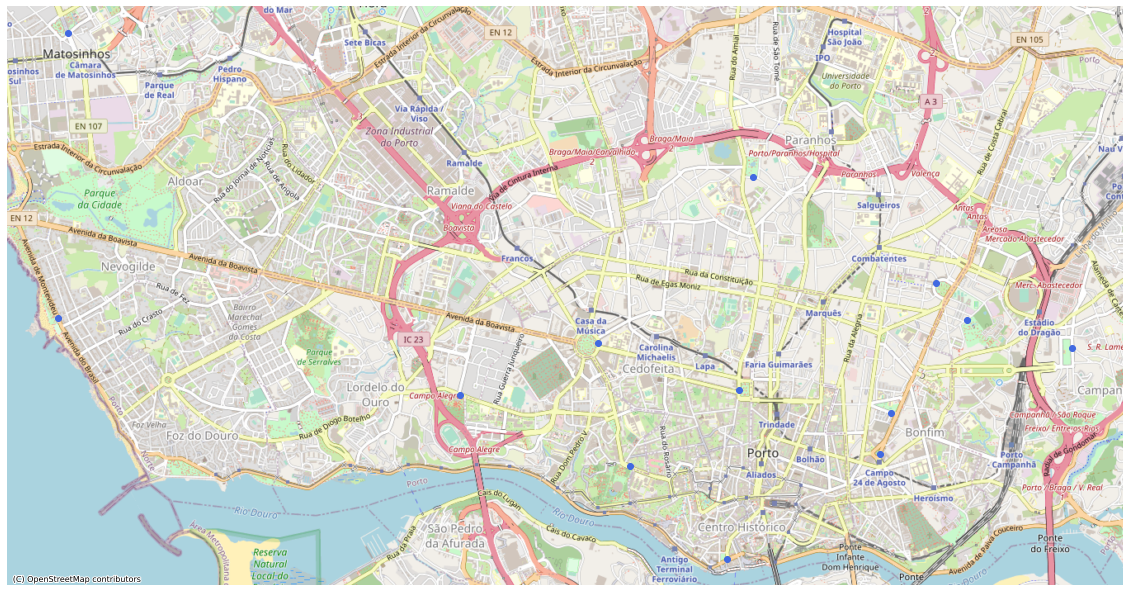

In [161]:
# Plotting the green spaces for Porto

ax = geo_df[geo_df.city == 'Porto']['geometry'].plot(figsize=(20, 20), color = 'royalblue', alpha = 1)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

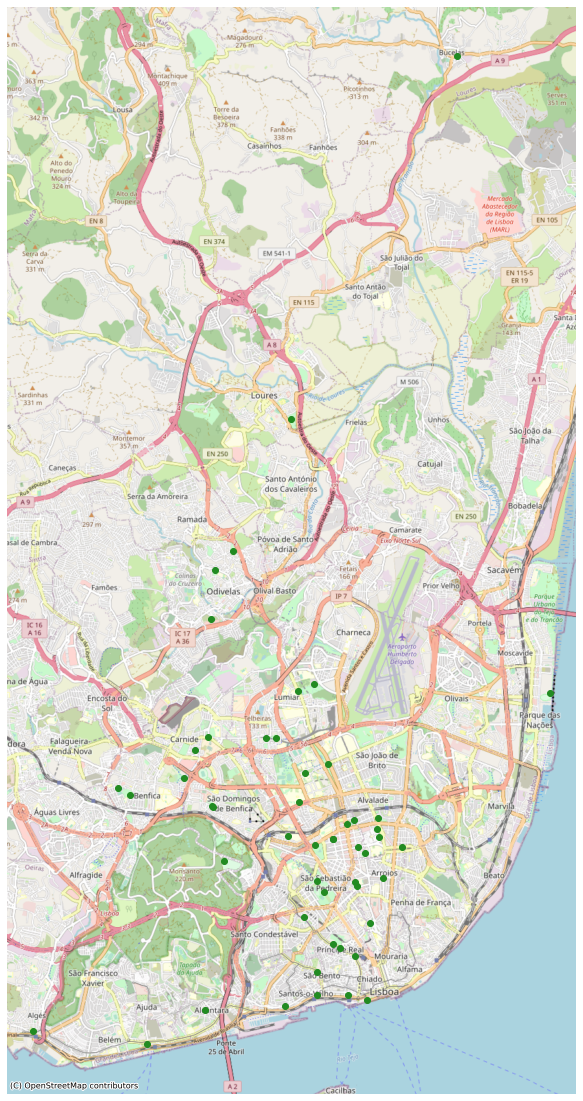

In [162]:
# Plotting the green spaces for Lisboa

ax = geo_df[geo_df.city == 'Lisboa']['geometry'].plot(figsize=(20, 20), color = 'forestgreen', alpha = 1)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

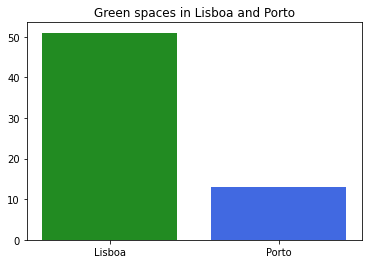

In [163]:
# Comparing the number of green spaces in both locations

plt.bar(x=["Lisboa", "Porto"], 
        height=[green_df[green_df.city == 'Lisboa']['Green_Zone_name'].nunique(), green_df[green_df.city == 'Porto']['Green_Zone_name'].nunique()],
        color = ['forestgreen', 'royalblue'])

plt.title('Green spaces in Lisboa and Porto')
plt.show()

### Lisbon vs. Porto - first insights 

- There are a lot more green spaces in lisbon than in Porto (at least in this dataset).

- It's important to note that Porto already has some projects in development to rehabilitate and expand the already built green spaces. So, although it seems like it wasn't a priority in the past, Porto is taking some steps to turn 'greener'. This topic will be expanded in the conclusion, with links to the information sources.

- Most of the green areas in Lisbon are really condensend in the 'old'/turistic part of town and closer to the sea, although we can actually see some green spaces in urban areas of the perifery, like São Domingos de Benfica and Carnide.

In [164]:
# Sorting our dataframe by demand

geo_df.sort_values(by="Green Zones Daily Average Demand", ascending=False).head(3)

,Green_Zone_name,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area,Daily average of people in influence area (Non-Residents),Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y,city,geometry
42,JRD. CP. VINTE E QUATRO DE AGOSTO,0,1,0,3193.372906,52834.126879,16782.664422,5428,10994,24265,0.271337,0.149062,-8.598670,41.14934,Porto,POINT (-957199.566 5034394.297)
34,JARDIM FUNDAÇÃO CALOUSTE GULBENKIAN,92,93,58,1291.870084,36577.848107,30892.425376,3521,24581,59559,0.161672,0.197283,-9.155130,38.73805,Lisboa,POINT (-1019144.410 4684218.640)
44,PARQUE DA CIDADE DE LOURES,1,9,4,1047.505649,6008.626849,17235.051457,5028,10598,27362,0.161501,0.209341,-9.161535,38.82598,Lisboa,POINT (-1019857.411 4696775.266)


### Demand Insights 

- Maybe unexpectedly, Porto has the green space that is most visited: [Campo 24 de Agosto](https://pt.wikipedia.org/wiki/Campo_de_Vinte_e_Quatro_de_Agosto) is the most visited (by far!) with no museums and only 1 parking lot! Surprising! **But why?** The reason is simple: **it's a huge accessibility center: the bus stops are huge and there is a huge variety of destinations that citizens can access through this point, either from bus or from train.** This is the most important factor for this green space in specific and it's not reflected in this dataset.

- Regarding second park with the most affluence, although having great accessibility too (subway, numerous bus stops and even a great number of parking lots), people go there mainly for **culture and/or leisure time**. [Gulbenkian](https://gulbenkian.pt/jardim/) always has multiple cultural events happening, from art exhibitions to live concerts or cinema being reproduced. It is also a really important cultural mark in the city. The garden is also open to the public and really well maintained and conserved, which makes it a really well-known attraction in the middle of a very urban part of town. Again, this "purpose" factor is not reflected in the dataset.

- The third most demanded park, [Parque da Cidade de Loures](https://www.allaboutportugal.pt/pt/loures/jardins/parque-da-cidade-de-loures), also serves a completely different purpose: **it's mainly a family place,** with two parks for kids with activities for them and a space/big gymnasium that is used for several sports pratice or different activities

The insight taken from this is: **different green spaces have different purposes and that matters when analyzing the demand and understanding what went right and wrong.** Is it a point that unites various transportations points and intersections of the city? Is it of cultural importance? Is it for kids and families? Is it close to a viewpoint (a.k.a. "miradouro")? Unfortunately, this variable is not created in our dataset, but it's something that we think would help a model perform and to understand in general the demand for these spaces in different locations of the cities. It would be enough to create a column called "purpose" with maybe less than 10 different categorical values that it could take.

Another insight is that **there is no demand if there is no accessibility**. All the top gardens have great access, either by road or by public transportation. This is crucial for the success of a green space and is crucial for making the community engaged with the space. It's really important to have this in mind when picking where the next green spaces should be built. That's why we recommend to unite this dataset with a column named "Number of Public Transportation Routes" that represents the number of public transportation routes that one can take from and to there.

In [19]:
df_lisboa = green_df[green_df['city'] == 'Lisboa']

df_porto = green_df[green_df['city'] == 'Porto']

df_lisboa

,Green_Zone_name,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area,Daily average of people in influence area (Non-Residents),Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y,city,geometry
1,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.199490,38.69674,Lisboa,POINT (-9.19949 38.69674)
2,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.157570,38.75294,Lisboa,POINT (-9.15757 38.75294)
3,JARDIM ALAMEDA DOM AFONSO HENRIQUES,105,175,84,41.485945,6008.626849,17235.051457,5028,10598,27362,0.161501,0.209341,-9.132070,38.73757,Lisboa,POINT (-9.13207 38.73757)
4,JARDIM AMÁLIA RODRIGUES,8,8,4,5.768512,32809.647241,7104.740926,2472,6729,15460,0.240815,0.163131,-9.154590,38.73062,Lisboa,POINT (-9.15459 38.73062)
5,JARDIM AMÉLIA CARVALHEIRA,104,139,72,57.137086,491.636442,9928.080489,2041,4529,12701,0.104874,0.260294,-9.150180,38.73919,Lisboa,POINT (-9.15018 38.73919)
6,JARDIM ANTÓNIO NOBRE,93,79,50,4.468216,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.144540,38.71502,Lisboa,POINT (-9.14454 38.71502)
7,JARDIM AVELAR BROTERO,10,3,3,2.669232,4306.692559,1485.605277,2837,6982,15584,0.295239,0.157662,-9.184300,38.70389,Lisboa,POINT (-9.18430 38.70389)
9,JARDIM BENTO MARTINS,5,10,5,13.560461,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.186990,38.75755,Lisboa,POINT (-9.18699 38.75755)
10,JARDIM BOTÂNICO LISBOA,105,166,93,90.464569,6158.589427,8136.902253,6464,19554,48629,0.162598,0.209196,-9.150310,38.71742,Lisboa,POINT (-9.15031 38.71742)
12,JARDIM BRAAMCAMP FREIRE,99,123,65,11.704812,36577.848107,30892.425376,3521,24581,59559,0.161672,0.197283,-9.140400,38.72178,Lisboa,POINT (-9.14040 38.72178)


In [166]:
y = df_lisboa[['Green Zones Daily Average Demand']]

X = df_lisboa.loc[:, df_lisboa.columns != 'Green Zones Daily Average Demand'].iloc[:, 1:-4]

In [167]:
def correlation_matrix(data_df):
        """Builds the correlation matrix with the respective columns and returns it

        Returns:
        -------

            plt.show(): returns plt graph that is a correlation matrix between
            some of the relevant variables in the dataset.
        """

        df_corr = data_df
        corr_matrix = df_corr.corr()
        plt.subplots(figsize=(12, 8))

        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(200, 20, as_cmap=True)

        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(
            corr_matrix,
            mask=mask,
            cmap=cmap,
            annot=True,
            vmax=0.3,
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.5},
        )

        plt.title("\nCorrelation Matrix", {"fontsize": 16})

        return plt.show()

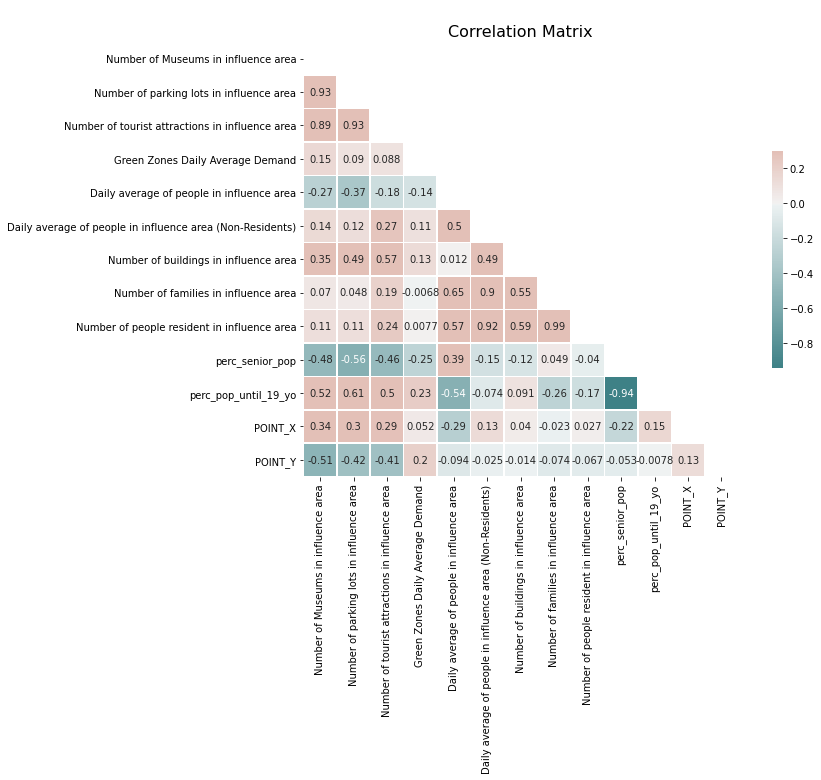

In [168]:
correlation_matrix(df_lisboa)

### Relevant Green Zones Demand Correlation in Lisbon: 

There are 2 important **positive correlations** with Green Areas demand:

- Percentage of people until 19 years old (23% correlation): Does this mean the green spaces are used by families and teenagers? It's something that we have to investigate further.

- Number of Museums in Influence Area (15% correlation): Most of the green spaces are used by people that go see turist/cultural attractions? Is it mainly used by tourists? These are all questions that would be important to clear out.


There is 1 important **negative correlation** with Green Areas demand:

- Percentage of Senior Population (-25%): Why don't senior people in the area use the green areas? Is it because there are a lot of ups and downs in the streets when you go to the green areas by foot? How is the accessbility for senior people to reach these areas? Most probably something has to be done about this (if it's the real cause, something we can't infer from correlation).

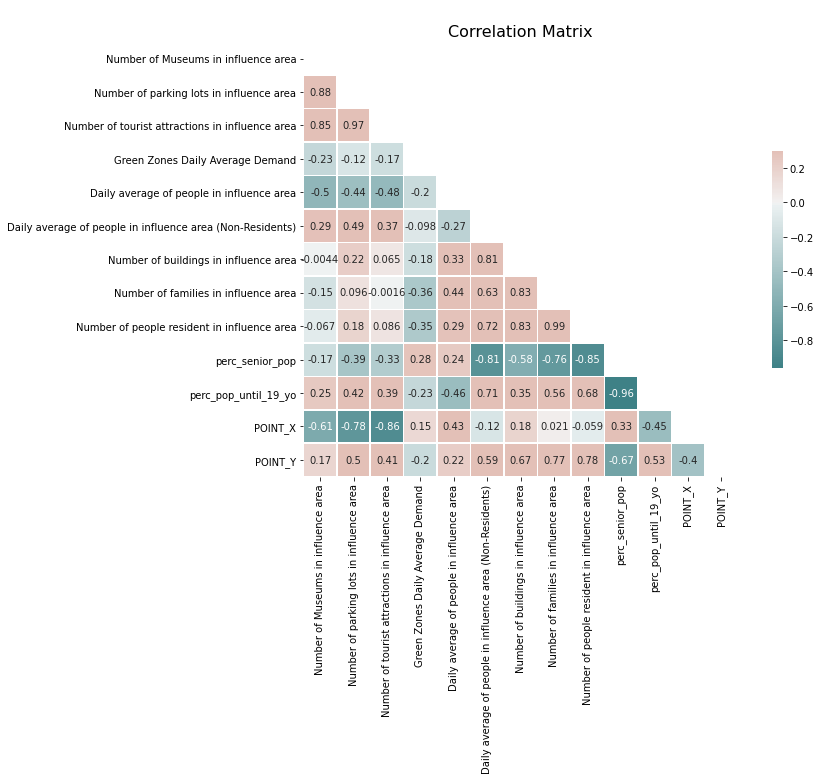

In [169]:
correlation_matrix(df_porto)

### Relevant Green Zones Demand Correlation in Porto: 

- The correlation distribution is vastly different in Porto. For example, most of the variables have a negative correlation, something that isn't seen in Lisbon's case.

- Another interesting point is that the percentage of senior population is the variable with the highest positive correlation and the percentage population until 19 years old is actually the variable with the highest negative correlation! Are the two cities that different? Or was it about the parks that were included for Porto?

- A possible explanation for this difference between the two cities is that we have a ver low number of data points in both datasets (especially the Porto one) making this analysis biased.

---

## Important Decision Here:

Due to the very low amount of parks in Porto in the dataset and the big differences in the correlation matrices, we have decided to **work with Lisbon parks only for modelling**. Although this entails reducing the total datapoints even further, it increases the consistency (crucial for model accuracy), since the correlations are so different for Porto parks. Another reason for this decision was that we could not find data on the metro stations for the city of Porto, something we need in order to build a model that considers the distance between the Parks and metro stations as a feature (done below).

---

## Baseline Model - Lisbon Data

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [172]:
# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [173]:
# Creating a pre-processing pipeline

numeric_features = X_train.columns#['vehicle_year', 'engine_capacity_bins', 'engine_power_bins', 'damaged', 'is_business']
numeric_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(numeric_features)),
    ('scaler', MinMaxScaler())
])

preprocessing_pipeline = ColumnTransformer([
        ("num", numeric_pipeline, numeric_features),
    ], remainder='passthrough', sparse_threshold=0)

In [174]:
# Use the preprocessing pipeline with a simple linear regressor
linear_model_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('linear', LinearRegression()) 
])

# Performing 5-fold cross-validation with the linear model pipeline on the training set to 
# get a more real prediction sand not have overfitting affect the score.
y_train_pred = cross_val_predict(linear_model_pipeline, X_train, 
                           y_train, cv=10)


In [175]:
# Creating a function that prints out different metrics for a regression problem

def scores(y_true, y_pred):
    print('The R2 score with cross-validation is', r2_score(y_true=y_true, y_pred=y_pred))
    print('Mean Squared Error with cross-validation is', mean_squared_error(y_true, y_pred))
    print('The RMSE with cross-validation is', mean_squared_error(y_true, y_pred, squared=False))
    print('Mean Absolute Error with cross-validation is', mean_absolute_error(y_true, y_pred))

In [176]:
print('Linear Regression results in training data:\n')
scores(y_train, y_train_pred)

Linear Regression results in training data:

The R2 score with cross-validation is -0.5321350900864346
Mean Squared Error with cross-validation is 128798.9457185129
The RMSE with cross-validation is 358.88570007526477
Mean Absolute Error with cross-validation is 242.10028049919913


#### Baseline Model Insights

- The model has a negative R-Squared and high error. Most likely the data is not linear and the fact that we have less than 70 data points affected the model negatively.
- We will now try to improve these metrics by trying out some appropriate models.

## Getting a Better Model
Here we show how we got to the best model for this case (Spoiler: it's a random forest and, as expected, it's not that good)

In [178]:
# Changing the Simple Linear Model for the Ridge and Lasso Regression

# Use it with a classifier/regressor
lasso_model_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('lasso', Lasso()) 
])


# Performing 3-fold cross-validation with the lasso model pipeline on the training set to 
# get a more real prediction sand not have overfitting affect the score.
# This time, 3-fold cross-validation is done just because it takes a long time to run.
y_train_pred = cross_val_predict(lasso_model_pipeline, X_train, 
                           y_train, cv=10)

# Calculating MSE, RMSE, R2 Score
print('Lasso Regression results in training data:\n')
scores(y_train, y_train_pred)

Lasso Regression results in training data:

The R2 score with cross-validation is -0.4868150779001039
Mean Squared Error with cross-validation is 124989.118616896
The RMSE with cross-validation is 353.5380016587976
Mean Absolute Error with cross-validation is 235.7819738280779


In [179]:
# Use it with a classifier/regressor
ridge_model_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('ridge', Ridge()) 
])

# Performing 3-fold cross-validation with the ridge model pipeline on the training set to 
# get a more real prediction sand not have overfitting affect the score.
# This time, 3-fold cross-validation is done just because it takes a long time to run.
y_train_pred = cross_val_predict(ridge_model_pipeline, X_train, 
                           y_train, cv=10)


# Calculating MSE, MAE, RMSE, R2 Score
print('Ridge Regression results in training data:\n')
scores(y_train, y_train_pred)

Ridge Regression results in training data:

The R2 score with cross-validation is -0.2307851582425522
Mean Squared Error with cross-validation is 103465.96185502855
The RMSE with cross-validation is 321.6612532696914
Mean Absolute Error with cross-validation is 193.8189525274169


In [180]:
# Use it with a classifier/regressor
dt_model_pipeline = Pipeline([
    ('preprocessor', preprocessing_pipeline),
    ('dt', DecisionTreeRegressor()) 
])

# Performing 3-fold cross-validation with the decision tree model pipeline on the training set to 
# get a more real prediction sand not have overfitting affect the score.
# This time, 3-fold cross-validation is done just because it takes a long time to run.
y_train_pred = cross_val_predict(dt_model_pipeline, X_train, 
                           y_train, cv=10)


# Calculating MSE, MAE, RMSE, R2 Score
print('Decision Tree Regressor results in training data:\n')
scores(y_train, y_train_pred)

Decision Tree Regressor results in training data:

The R2 score with cross-validation is -1.089977467084903
Mean Squared Error with cross-validation is 175693.9685526016
The RMSE with cross-validation is 419.15864365726924
Mean Absolute Error with cross-validation is 222.9396415921052


In [149]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create the parameter grid for grid hyperparameter search
param_grid = {
    'max_depth': range(80, 100, 5),
    'min_samples_leaf': [3, 5, 8, 11],
    'n_estimators': range(100, 200, 10)
}

rf_clf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1)

grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [150]:
# Showing the hyperparameters for the Random Forest Regressor
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [181]:
# Predicting y_train
y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train, 
                           y_train['Green Zones Daily Average Demand'], cv=10)

In [182]:
print('Random Forest Regressor results in training data:\n')
scores(y_train, y_train_pred)


Random Forest Regressor results in training data:

The R2 score with cross-validation is -0.07171726589043481
Mean Squared Error with cross-validation is 90093.91851160326
The RMSE with cross-validation is 300.1564900374524
Mean Absolute Error with cross-validation is 167.9660621565538


In [183]:
# Random Forest Model on the test set
y_test_pred = cross_val_predict(grid_search.best_estimator_, X_test, 
                           y_test['Green Zones Daily Average Demand'], cv=10)

print('Random Forest Regressor results in test data:\n')
scores(y_test, y_test_pred)

Random Forest Regressor results in test data:

The R2 score with cross-validation is -0.10163903760519455
Mean Squared Error with cross-validation is 19175.536301090084
The RMSE with cross-validation is 138.47576069872332
Mean Absolute Error with cross-validation is 116.61711721467947


In [184]:
# Ridge Model on the test set
y_test_pred = cross_val_predict(ridge_model_pipeline, X_test, 
                           y_test['Green Zones Daily Average Demand'], cv=10)

print('Ridge Regressor results in test data:\n')
scores(y_test, y_test_pred)

Ridge Regressor results in test data:

The R2 score with cross-validation is -1.0618257155122026
Mean Squared Error with cross-validation is 35888.900542479154
The RMSE with cross-validation is 189.44366060251042
Mean Absolute Error with cross-validation is 160.55739578584976


In [185]:
for i in range(len(X.columns)):
    print(X.columns[i])
    print(grid_search.best_estimator_.feature_importances_[i])

Number of Museums in influence area
0.019834358396159903
Number of parking lots in influence area
0.09894401171073391
Number of tourist attractions in influence area
0.03952631044959414
Daily average of people in influence area
0.03969829664308756
Daily average of people in influence area (Non-Residents)
0.0
Number of buildings in influence area
0.10496891123755459
Number of families in influence area
0.0189499032078954
Number of people resident in influence area
0.0
perc_senior_pop
0.4362138850220819
perc_pop_until_19_yo
0.0


### Feature Importance Insights - Random Forest:

- The random forest disregards the variables "% of population until 19 years old", "Daily average of people in influence area (Non-Residents)" and the "number of people resident in influence area" - only the second exclusion is consistent with the correlation matrix, since the two other variables have some of the large correlations in the matrix. For that reason, and due to the model's poor performance, here we can only conclude that the amount of non-residents in the influence area is not an important variable.

- Surprisingly, the feature that the model considers most important is the % of senior population, followed by the number of buildings in influence area. The latter must be beacause parks nearest to the city centres are more demanded.

Although this model is our best model, the value of the metrics and the feature importance it gives to different variables makes us think that we can't make recommendation on the output of the model alone; the group thinks the best approach to this problem will be analyzing the model output as well as the correlation matrix to give a more complete and accurate analysis/recommendation.

### Best Model Insights:

##### **Because the Random Forest Model performed better than the Ridge model in both the training and test dataset, we will assume Random Forest as our best model.**

However, the results of our best model aren't satisfatory: it has a negative R2, the MAE and RMSE are too big to make any good predictions. We believe this is because we only have 64 data points.


#### **Biggest Limitation:**

This simple model is still lacking a lot - **its performance is especially poor because of the reduced dataset we have**. Unfortunately, for this reason, **we can't say that the results from this model are promising.**

#### Assumption:

- Assuming this is the model that performs better in all situations in relation to this problem, this is the model we will continue with for the last analysis: **parks near vs far away from metro stations**.

## Parks Near vs Far Away From Metro Stations (Lisbon)

#### Getting metro station coordinates in Lisbon:

In [9]:
link  = 'https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/POITransportes/FeatureServer/2/query?where=1%3D1&outFields=*&f=pgeojson'

with urllib.request.urlopen(link) as url:
    data = json.loads(url.read().decode())

In [10]:
# Getting both the station name and coordinates into a dictionary
dic = {}
for i in range(len(data['features'])):
    dic[data['features'][i]['properties']['INF_NOME']] = data['features'][i]['geometry']['coordinates']

In [11]:
metro_df = pd.DataFrame()
metro_df['station_name'] = dic.keys()
metro_df['coordinates'] = dic.values()

In [12]:
metro_df.head()

,station_name,coordinates
0,Chelas,"(-9.11391723740532, 38.7549445533084)"
1,Alvalade,"(-9.14401263737641, 38.7531285992408)"
2,Intendente,"(-9.13523921600122, 38.7230823966241)"
3,Alto dos Moinhos,"(-9.18001577188089, 38.7498812634593)"
4,São Sebastião,"(-9.15385312166352, 38.7343309951123)"


In [13]:
# Getting the latitude and longitude off the coordinates and into new columns
metro_df['latitude'] = metro_df['coordinates'].apply(lambda x: x[0])
metro_df['longitude'] = metro_df['coordinates'].apply(lambda x: x[1])

In [14]:
metro_df.drop(columns='coordinates', inplace=True)

In [15]:
metro_df.head(10)

,station_name,latitude,longitude
0,Chelas,-9.113917,38.754945
1,Alvalade,-9.144013,38.753129
2,Intendente,-9.135239,38.723082
3,Alto dos Moinhos,-9.180016,38.749881
4,São Sebastião,-9.153853,38.734331
5,Restauradores,-9.142012,38.715756
6,Martim Moniz,-9.135882,38.717412
7,Praça de Espanha,-9.159332,38.737685
8,Cabo Ruivo,-9.105134,38.762932
9,Colégio Militar,-9.189273,38.753201


#### Calculating the distance between each green park and its closest metro station in Lisbon:

In [16]:
metro_geo_df = gpd.GeoDataFrame(
    metro_df, geometry = gpd.points_from_xy(metro_df.latitude, metro_df.longitude))

metro_geo_df.crs = "EPSG:4326"
metro_geo_df = metro_geo_df.to_crs(epsg=3857)

In [17]:
# Creating function to find closest metro station

def closest_station(df1, df2, row):
    dist_list = []
    for station in df1.index:
        dist_list.append((df1.geometry.iloc[station].distance(df2.geometry.iloc[row])))
    
    return int(np.min(dist_list))


In [21]:
geo_df_lisboa = geo_df[geo_df.city == 'Lisboa']

new_column = []
for row in range(df_lisboa.shape[0]):
    new_column.append(closest_station(metro_geo_df, geo_df_lisboa, row))
    
df_lisboa['closest_station_m'] = new_column

<ipython-input-21-7d831922d5e2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lisboa['closest_station_m'] = new_column


In [196]:
df_lisboa.head(5)

,Green_Zone_name,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area,Daily average of people in influence area (Non-Residents),Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y,city,geometry,closest_station_m
1,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.19949,38.69674,Lisboa,POINT (-9.19949 38.69674),5988
2,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.15757,38.75294,Lisboa,POINT (-9.15757 38.75294),274
3,JARDIM ALAMEDA DOM AFONSO HENRIQUES,105,175,84,41.485945,6008.626849,17235.051457,5028,10598,27362,0.161501,0.209341,-9.13207,38.73757,Lisboa,POINT (-9.13207 38.73757),84
4,JARDIM AMÁLIA RODRIGUES,8,8,4,5.768512,32809.647241,7104.740926,2472,6729,15460,0.240815,0.163131,-9.15459,38.73062,Lisboa,POINT (-9.15459 38.73062),453
5,JARDIM AMÉLIA CARVALHEIRA,104,139,72,57.137086,491.636442,9928.080489,2041,4529,12701,0.104874,0.260294,-9.15018,38.73919,Lisboa,POINT (-9.15018 38.73919),454


#### Creating a "closest_station_bins" column that is 1 if the distance to the closest subway is lower than 500m, 2 if it's between 500m and 1km and 3 if the distance to the metro station is more than 1km:

In [22]:
df_lisboa["closest_station_bins"] = pd.cut(df_lisboa["closest_station_m"],
                               bins=[0., 500, 1000, np.inf],
                               labels=[1, 2, 3])

df_lisboa

<ipython-input-22-99584d50c020>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lisboa["closest_station_bins"] = pd.cut(df_lisboa["closest_station_m"],


,Green_Zone_name,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area,Daily average of people in influence area (Non-Residents),Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y,city,geometry,closest_station_m,closest_station_bins
1,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.199490,38.69674,Lisboa,POINT (-9.19949 38.69674),5988,3
2,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.157570,38.75294,Lisboa,POINT (-9.15757 38.75294),274,1
3,JARDIM ALAMEDA DOM AFONSO HENRIQUES,105,175,84,41.485945,6008.626849,17235.051457,5028,10598,27362,0.161501,0.209341,-9.132070,38.73757,Lisboa,POINT (-9.13207 38.73757),84,1
4,JARDIM AMÁLIA RODRIGUES,8,8,4,5.768512,32809.647241,7104.740926,2472,6729,15460,0.240815,0.163131,-9.154590,38.73062,Lisboa,POINT (-9.15459 38.73062),453,1
5,JARDIM AMÉLIA CARVALHEIRA,104,139,72,57.137086,491.636442,9928.080489,2041,4529,12701,0.104874,0.260294,-9.150180,38.73919,Lisboa,POINT (-9.15018 38.73919),454,1
6,JARDIM ANTÓNIO NOBRE,93,79,50,4.468216,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.144540,38.71502,Lisboa,POINT (-9.14454 38.71502),300,1
7,JARDIM AVELAR BROTERO,10,3,3,2.669232,4306.692559,1485.605277,2837,6982,15584,0.295239,0.157662,-9.184300,38.70389,Lisboa,POINT (-9.18430 38.70389),4017,3
9,JARDIM BENTO MARTINS,5,10,5,13.560461,42877.741202,17497.825376,1775,17185,41163,0.161747,0.204917,-9.186990,38.75755,Lisboa,POINT (-9.18699 38.75755),670,2
10,JARDIM BOTÂNICO LISBOA,105,166,93,90.464569,6158.589427,8136.902253,6464,19554,48629,0.162598,0.209196,-9.150310,38.71742,Lisboa,POINT (-9.15031 38.71742),628,2
12,JARDIM BRAAMCAMP FREIRE,99,123,65,11.704812,36577.848107,30892.425376,3521,24581,59559,0.161672,0.197283,-9.140400,38.72178,Lisboa,POINT (-9.14040 38.72178),603,2


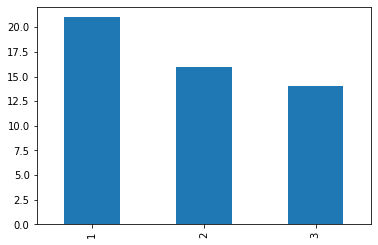

In [198]:
df_lisboa['closest_station_bins'].value_counts().plot.bar()

Most of the green spaces have a subway station less than 500 meters away.

Unfortunately, there are still a considerable amount of green spaces that are more than 1KM away from a subway station. This is fine as long as there are other transportation options. Lets check that:

In [29]:
# Finding the "low accessibility" parks in Lisbon - at least between metro and parking lots

df_lisboa[(df_lisboa['closest_station_bins'] == 3) & (df_lisboa['Number of parking lots in influence area'] < 10)]

,Green_Zone_name,Number of Museums in influence area,Number of parking lots in influence area,Number of tourist attractions in influence area,Green Zones Daily Average Demand,Daily average of people in influence area,Daily average of people in influence area (Non-Residents),Number of buildings in influence area,Number of families in influence area,Number of people resident in influence area,perc_senior_pop,perc_pop_until_19_yo,POINT_X,POINT_Y,city,geometry,closest_station_m,closest_station_bins
7,JARDIM AVELAR BROTERO,10,3,3,2.669232,4306.692559,1485.605277,2837,6982,15584,0.295239,0.157662,-9.184300,38.70389,Lisboa,POINT (-9.18430 38.70389),4017,3
16,JARDIM DA LUZ,0,0,0,49.334537,27936.088720,6794.558127,1804,9064,23316,0.155516,0.219163,-9.183430,38.76039,Lisboa,POINT (-9.18343 38.76039),1041,3
19,JARDIM DE BUCELAS,0,1,0,5.665942,250.571925,552.667924,2063,1893,4663,0.226678,0.174780,-9.117490,38.90102,Lisboa,POINT (-9.11749 38.90102),17978,3
37,JARDIM JOÃO FREDERICO LUDOVICE,1,9,0,11.818563,36893.356166,14666.685976,2811,16735,36821,0.289346,0.151598,-9.207210,38.74978,Lisboa,POINT (-9.20721 38.74978),2055,3
43,MATA DE BENFICA,0,3,0,12.466047,36893.356166,14666.685976,2811,16735,36821,0.289346,0.151598,-9.203980,38.74836,Lisboa,POINT (-9.20398 38.74836),1777,3
44,PARQUE DA CIDADE DE LOURES,1,9,4,1047.505649,6008.626849,17235.051457,5028,10598,27362,0.161501,0.209341,-9.161535,38.82598,Lisboa,POINT (-9.16154 38.82598),6632,3
54,PARQUE URBANO DA QUINTA NOVA,0,3,0,153.690076,36577.848107,30892.425376,3521,24581,59559,0.161672,0.197283,-9.176870,38.79877,Lisboa,POINT (-9.17687 38.79877),3349,3
55,PARQUE URBANO DO CASTELINHO,0,1,0,215.385850,36577.848107,30892.425376,3521,24581,59559,0.161672,0.197283,-9.181560,38.79484,Lisboa,POINT (-9.18156 38.79484),3276,3
56,PARQUE URBANO DO SILVADO,1,1,1,8.140077,36577.848107,30892.425376,3521,24581,59559,0.161672,0.197283,-9.182490,38.78463,Lisboa,POINT (-9.18249 38.78463),2649,3


As we can see, these 9 parks could probably benefit from more accessibility features. However, it would be very positive to evaluate this against the number of bus stops and lines in their surroundings.


#### Now let's check the correlation of the near metro stations variables with the demand:

We will compare this with the importance of the features of our model

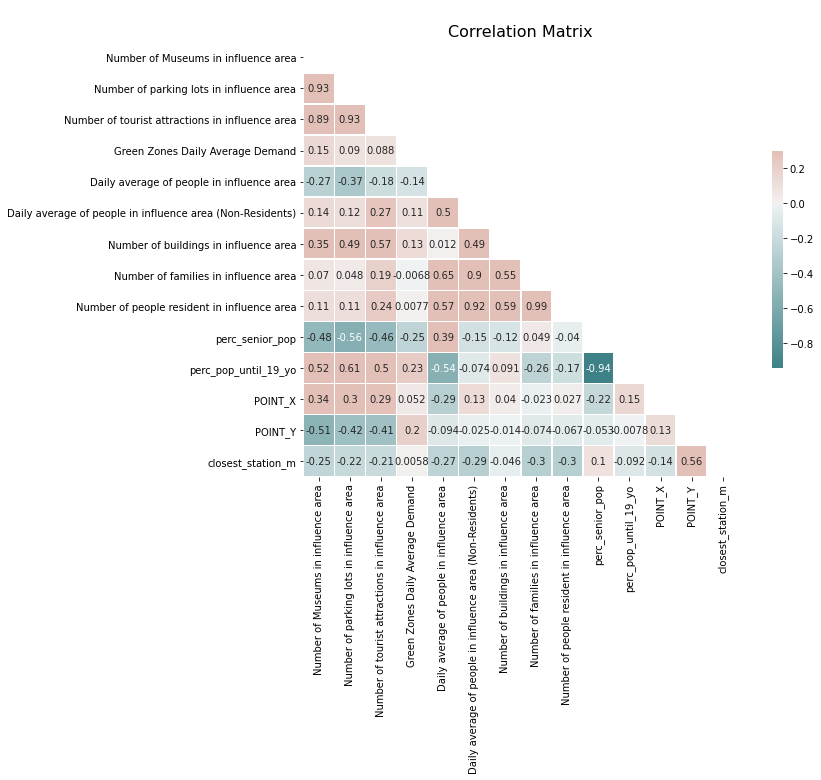

In [199]:
correlation_matrix(df_lisboa)

Our closest_station_m variable is not really correlated to the Green Zones Deamnd variable. The group thinks this is strange because accessibility is such a big issue when it comes to the demand of green spaces. 

**Why is it not strongly correlated?**

Probably because:
- Our dataset is really small
- We don't have the number of bus stations around the green space, which would be a crucial part in building an "accessibility" variable.
- A lot of people might still use alternative methods to get to parks, like private transport (car, uber) or bus.

#### Applying the best model (Random Forest) to the full data, with distance to metro stations:

In [200]:
y = df_lisboa[['Green Zones Daily Average Demand']]

X = df_lisboa.loc[:, df_lisboa.columns != 'Green Zones Daily Average Demand'].iloc[:, 1:].drop(columns=["city", "geometry", "closest_station_bins"])

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [202]:
# Create the parameter grid for grid hyperparameter search
param_grid = {
    'max_depth': range(80, 100, 5),
    'min_samples_leaf': [3, 5, 8, 11],
    'n_estimators': range(100, 200, 10)
}

rf_clf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1)

grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [203]:
# Predicting y_train
y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train, 
                           y_train['Green Zones Daily Average Demand'], cv=10)
print('Random Forest Regressor results in training data:\n')
scores(y_train, y_train_pred)

# Random Forest Model on the test set
y_test_pred = cross_val_predict(grid_search.best_estimator_, X_test, 
                           y_test['Green Zones Daily Average Demand'], cv=10)

print('\nRandom Forest Regressor results in test data:\n')
scores(y_test, y_test_pred)

Random Forest Regressor results in training data:

The R2 score with cross-validation is -0.0967035803897307
Mean Squared Error with cross-validation is 92194.39319280058
The RMSE with cross-validation is 303.63529635534894
Mean Absolute Error with cross-validation is 177.8143710391093

Random Forest Regressor results in test data:

The R2 score with cross-validation is -0.09402630613291918
Mean Squared Error with cross-validation is 19043.026283095078
The RMSE with cross-validation is 137.99647199510238
Mean Absolute Error with cross-validation is 115.74775209597905


In [204]:
for i in range(len(X.columns)):
    print(X.columns[i])
    print(grid_search.best_estimator_.feature_importances_[i])

Number of Museums in influence area
0.043808454303205395
Number of parking lots in influence area
0.08872179462339712
Number of tourist attractions in influence area
0.07696600191158838
Daily average of people in influence area
0.035922765470647704
Daily average of people in influence area (Non-Residents)
0.0177611468044108
Number of buildings in influence area
0.1403109720332491
Number of families in influence area
0.00839213851190836
Number of people resident in influence area
0.01817363003474023
perc_senior_pop
0.38011671162134314
perc_pop_until_19_yo
0.017358321734227394
POINT_X
0.018394674594084857
POINT_Y
0.13289703361505514
closest_station_m
0.021176354742142536


### Metro Station Distance Importance Insights - Random Forest:

- The distance to closest metro station seems to not be such an important variable. This does not mean that accessibility is not key, it just means that people probably go to these parks with several other means of transport. This is consistent with the correlation matrix.

---

## Conclusions

### Scalability and Impact

#### Activities vs. Nature

- While functionality and activities (restaurants, sports fields, playgrounds, etc) matter a lot, in the age of humans needing to take a break off their stressed lives and overwhelming technology, nature and beauty seem to matter more and more.

- This is more of a hint that municipalities need to merge the concepts than that they should choose one, and this is happening: in the Quinta da Boavista, Maia, Porto (not in the dataset), for instance, a [restaurant](https://www.timeout.pt/porto/pt/noticias/maia-ha-uma-nova-esplanada-no-meio-da-natureza-052021) has been opened in the depths of nature that really captures this symbiosis.

- Improving and scaling this situation is a question of design. As suggested in the literature, the role of Green Park Designer must be embodied by professionals that tailor each park's design to its surroundings and communities).

- The importance of the nature and design attributes is also backed by TimeOut's latest [park recommendations in Lisbon](https://www.timeout.pt/lisboa/pt/coisas-para-fazer/os-melhores-parques-e-jardins-de-lisboa), which has emphasis on parks with either a lot of nature or that have been subject to restructuring or construction.

- Our best model suggests that one of the most important features is the number of buildings in influence area, probably because green parks nearest to the city centres are more demanded. City halls everywhere must ensure the population have enough spaces (and parks) at their disposal in these areas in particular.

#### Lisbon vs. Porto

##### Porto
- In general Porto seems to have way less green parks than Lisbon, which is reflected in this dataset. However, the city of Porto seems to be commited to closing this gap, notably through a more than €10 million [project](https://www.publico.pt/2020/11/23/local/noticia/camara-porto-seis-projectos-reabilitacao-expansao-parques-jardins-1940318), due to start this year, for the of **rehabilitation and expansion** of 6 of the City's parks.

- One of these parks is the **Jardim da Corujeira, present in the dataset**. This project is a much needed operation to a park that clearly needed rehabilitation, and that could have great potential. Notably, it currently only has **7 parking lots** within its influence area, and our recommendation is for the city hall to include more if they want to make the park more attractive, given that there are no metro stations nearby (only two bus stations). This kind of analysis, when scaled to all parks, can really impact the future of park accessibility.

- Porto has the park with **the most affluence by far, Jardim 24 de Agosto**, characterized by the surrounding public transportation access points very close - Metro lines A, B, C, E, and F (that's a lot of lines!) and [one of the major bus terminals in the city with buses that transport, annually, about 1.5 million passengers](https://pt.wikipedia.org/wiki/Terminal_Rodovi%C3%A1rio_do_Campo_24_de_Agosto). While this park only has 1 parking lot in its influence area, this is not such an important feature becuase of the public transportation factor, responsible for most people's presence there in the first place. This is an example of the nuance that must be considered in this kind of analysis.

- The correlation plots (even though biased by the very few datapoints!) shows that elderly people tend to visit these parks in Porto, which is great. However, younger people do not, as it the the variable with the most negative correlation - **the city hall should investigate into why that is and, quite possibly, make green parks more attractive to younger generations, for instance by shifting the Nature vs. Activities balance towards Activities**.

##### Lisbon
- Lisbon was the Green European Capital of 2020, the recogniton of an effort for the past and future that goes way beyond green parks but that has this compontent too: the city has [**compromised to have 25% of the city with green spaces until 2022**](https://observador.pt/2020/03/12/lisboa-a-capital-verde-europeia-que-esta-em-festa/).

- There has been a trend for quite some time in Lisbon to build more cycling roads, changing how roads are built and the addition of even more green social places. A very important segment of the city called [Praça de Espanha has been revamped and updated to be more green, more of a leisure space and (much) less traffic intense than before](https://www.lisboa.pt/nova-praca-de-espanha).

- The feature that the model considers most important is the % of senior population, which has a negative correlation with demand. This is absolutely consistent with the correlation matrix and ultimately confirms that **parks in Lisbon are not attractive to the elderly**. The motive for this must be evaluated further in depth.

#### Parks near metro stations vs. parks far away - Lisbon only

- Most of the green spaces in Lisbon have a subway station less than 500 meters away.

- Unfortunately, there are still a considerable amount of green spaces that are more than 1KM away from a subway station. This should be evalauted by the city hall (in this case Lisbon's, but the same could be done for Porto) in order to make sure there are enough acessibility alternatives (bus stations, parking lots, cycling ways, etc) in these cases specifically.

- The low correlation between this variable and demand possibly shows that, for Lisbon, lot of people might other methods to get to parks, like private transport (car, uber) or bus. However, due to the large number of public transportation options in lisbon, the city hall must incentivize the public transport options (at least for central city parks).

- The Random Forest's low consideration for the metro station distances variable also reflects that.

- The amount of non-residents in the influence area is not an important variable, which highlights again that overall accessibility is key (consistent with the literature).
   

#### More Specific Recommendations for Municipalities

- **Accessibility**: while it is very important, it is not necessary for all requirements to be filled. For instance, if a park has a lot of public transportation options, it is not so crucial for it to have that many parking lots available. A good balance in the cities must be achived, and of course the preference (especially for city-centre parks) must continue to be less parking lots and more public transportation options. In this regard, the dataset seems to be well balanced, but the future holds the need for even more public transportation options.

- Although this must be confirmed in the feature with the number of bus stops available, it seems that **the following parks could benefit from more accessibility options**:
    1. JARDIM AVELAR BROTERO
    2. JARDIM DA LUZ
    3. **JARDIM DE BUCELAS** - especially this one, in a non-central location (no good public transportation options), has too little parking lots.
    4. JARDIM JOÃO FREDERICO LUDOVICE
    5. MATA DE BENFICA
    6. PARQUE DA CIDADE DE LOURES
    7. PARQUE URBANO DA QUINTA NOVA
    8. PARQUE URBANO DO CASTELINHO
    9. PARQUE URBANO DO SILVADO
    

- The same analysis must be done for the city of Porto.

- Lisbon's city hall must try to understand why the elderly are not using the city's green parks and change that. One very plausible explanation (up for discussion) is bad accessibility.

---

### Future Work


- **Collect more data on:**:

    1. **Park Purpose** - parks must be categorized, especially according to what factos attract people there (i.e. what the park's role is in the community). Some parks do that through cultural events, like the Calouste Gulbenkian park in Lisbon, while others do that by having important public transportation stations around, like the Jardim 24 de Agosto, in Porto. There are several other characteristics that attract people, and it would be **absolutely crucial for minicipalities to start measuring, recordinding, and classifying these**. This would allow municipalities to know exactly **how to improve each park specifically by understanding how to better design the spaces for their different surroundings and communities.**
    
    2. **Accessibility** - while a count of parking lots is available in this dataset, each park must have, clearly identified and reflected in town hall databases, all its accessibility options, especially from **bus routes**.
    
    3. **Time spent on the parks** - in the future, it would be great to extract data on how the rough average time spent by people in each park, so that their purpose can be understood in even more depth, enabling an even better fitted design to each park.
    
##### Without these two crucial factors, a lot of general information is lost. This information is specifically important because it applies to **all parks**, and having it would enable the construction of much more comprehensive and generalizable models that could then be applied to predict demand much more accurately.


- **Model building when more data points are available:**

    1. Trying these models with more data points and features (namely the "purpose" column recommended above)

    2. Hypertuning the Random Forest even further which couldn't be done on the computer we used because of time and memory constraints.

    3. Applying K-Means to the bigger dataset - simple, effective and interpretable.
    
    4. Stacking different weak models.


### Thanks for reading through! We know it's a lot of text but... 64 rows and could not find a large (and appropriate) dataset D: